In [1]:
import torch
import torch.nn as nn
from torch.nn import init
import numpy as np

from torchvision.datasets import ImageFolder
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.data import random_split

import matplotlib.pyplot as plt

/Users/gwanpil/opt/anaconda3/envs/stock_prediction/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [32]:
file_dir = '/Users/gwanpil/Desktop/Datasets/preprocessing/Dataset/twin/image'


In [33]:
image_folder = ImageFolder(root=file_dir,                   # 다운로드 받은 폴더의 root 경로를 지정합니다.
                      transform=transforms.Compose([
                          transforms.ToTensor(), 
                      ]))


In [4]:
len(image_folder)

2250

In [5]:
image_loader = torch.utils.data.DataLoader(image_folder,         # image_folder를 지정
                                           batch_size=128,# 배치사이즈 지정
                                           shuffle=True,        # shuffle 여부 지정
                                           num_workers=0)       # num_workers 지정

In [6]:
# pytorch에서는 이미지 구조를 [Batch Size, Channel, Width, Height]의 구조를 가지고 있어
# matplotlib로 출력하기 위해서는 [Width, Height, Channel] 순서로 바꿔야함

def custom_imshow(img) :
    img = img.numpy()
    plt.imshow(np.transpose(img, (1,2,0)))
    plt.show()



In [7]:
def process() :
    for batch_idx, (inputs, targets) in enumerate(image_loader) :
        custom_imshow(inputs[0])

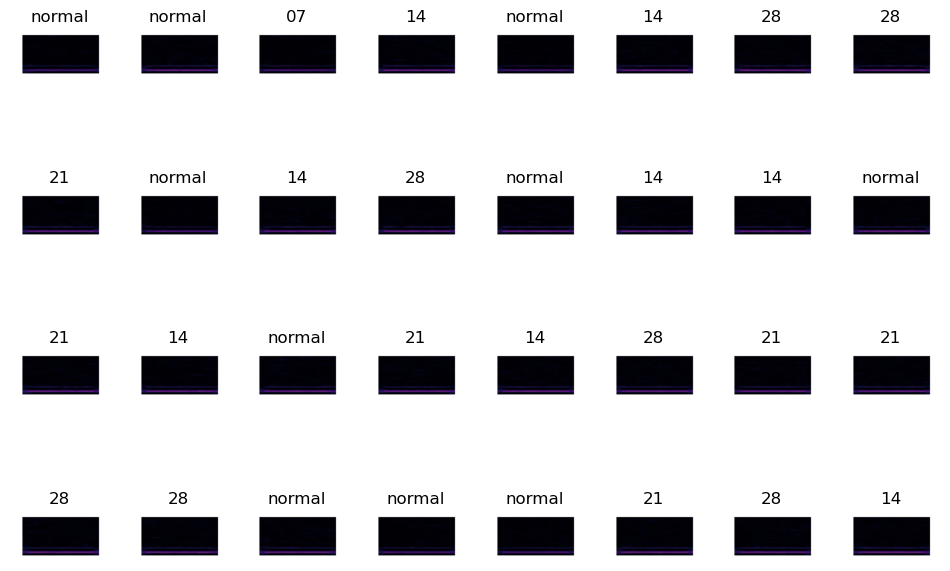

In [10]:
images, labels = next(iter(image_loader))

# ImageFolder의 속성 값인 class_to_idx를 할당
labels_map = {v:k for k, v in image_folder.class_to_idx.items()}

figure = plt.figure(figsize=(12, 8))
cols, rows = 8, 4

# 이미지를 출력합니다. RGB 이미지로 구성되어 있습니다.
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(images), size=(1,)).item()
    img, label = images[sample_idx], labels[sample_idx].item()
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    # 본래 이미지의 shape은 (3, 300, 300) 입니다.
    # 이를 imshow() 함수로 이미지 시각화 하기 위하여 (300, 300, 3)으로 shape 변경을 한 후 시각화합니다.
    plt.imshow(torch.permute(img, (1, 2, 0)))
plt.show()

In [11]:
image_folder.classes

['07', '14', '21', '28', 'normal']

### train/test set split

In [12]:
ratio = 0.8 # 학습셋(train set)의 비율을 설정합니다.

train_size = int(ratio * len(image_folder))
test_size = len(image_folder) - train_size
print(f'total: {len(image_folder)}\ntrain_size: {train_size}\ntest_size: {test_size}')

# random_split으로 8:2의 비율로 train / test 세트를 분할합니다.
train_data, test_data = random_split(image_folder, [train_size, test_size])


total: 2250
train_size: 1800
test_size: 450


In [13]:
batch_size = 32 # batch_size 지정
num_workers = 0 # Thread 숫자 지정 (병렬 처리에 활용할 쓰레드 숫자 지정)

train_loader = DataLoader(train_data, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=num_workers
                         )
test_loader = DataLoader(test_data, 
                         batch_size=batch_size,
                         shuffle=False, 
                         num_workers=num_workers
                        )


### 이미지 사이즈 확인

In [14]:
images, labels = next(iter(train_loader))

In [15]:
images[0].shape

torch.Size([3, 600, 1200])

### CPU 설정

In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


### 모델 정의

In [26]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        
        self.sequential = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1), 
            nn.ReLU(),
            nn.MaxPool2d(2, 2), 
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1), 
            nn.ReLU(),
            nn.MaxPool2d(2, 2), 
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1), 
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1), 
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1), 
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.fc = nn.Linear(32*85248, 3) # 7*7*128
    
    def forward(self, x):
        x = self.sequential(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x        

In [27]:
model = CNNModel() # Model 생성
model.to(device)   # device 에 로드 (cpu or cuda)


CNNModel(
  (sequential): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=2727936, out_features=3, bias=True)
)

### Hyper-Parameter 설정

In [28]:
# 옵티마이저를 정의합니다. 옵티마이저에는 model.parameters()를 지정해야 합니다.
optimizer = optim.Adam(model.parameters(), lr=0.0005)

# 손실함수(loss function)을 지정합니다. Multi-Class Classification 이기 때문에 CrossEntropy 손실을 지정하였습니다.
loss_fn = nn.CrossEntropyLoss()

## 모델 학습

In [21]:
from tqdm import tqdm  # Progress Bar 출력

In [29]:
def model_train(model, data_loader, loss_fn, optimizer, device):
    # 모델을 훈련모드로 설정합니다. training mode 일 때 Gradient 가 업데이트 됩니다. 반드시 train()으로 모드 변경을 해야 합니다.
    model.train()
    
    # loss와 accuracy 계산을 위한 임시 변수 입니다. 0으로 초기화합니다.
    running_loss = 0
    corr = 0
    
    # 예쁘게 Progress Bar를 출력하면서 훈련 상태를 모니터링 하기 위하여 tqdm으로 래핑합니다.
    prograss_bar = tqdm(data_loader)
    
    # mini-batch 학습을 시작합니다.
    for img, lbl in prograss_bar:
        # image, label 데이터를 device에 올립니다.
        img, lbl = img.to(device), lbl.to(device)
        
        # 누적 Gradient를 초기화 합니다.
        optimizer.zero_grad()
        
        # Forward Propagation을 진행하여 결과를 얻습니다.
        output = model(img)
        
        # 손실함수에 output, label 값을 대입하여 손실을 계산합니다.
        loss = loss_fn(output, lbl)
        
        # 오차역전파(Back Propagation)을 진행하여 미분 값을 계산합니다.
        loss.backward()
        
        # 계산된 Gradient를 업데이트 합니다.
        optimizer.step()
        
        # output의 max(dim=1)은 max probability와 max index를 반환합니다.
        # max probability는 무시하고, max index는 pred에 저장하여 label 값과 대조하여 정확도를 도출합니다.
        _, pred = output.max(dim=1)
        
        # pred.eq(lbl).sum() 은 정확히 맞춘 label의 합계를 계산합니다. item()은 tensor에서 값을 추출합니다.
        # 합계는 corr 변수에 누적합니다.
        corr += pred.eq(lbl).sum().item()
        
        # loss 값은 1개 배치의 평균 손실(loss) 입니다. img.size(0)은 배치사이즈(batch size) 입니다.
        # loss 와 img.size(0)를 곱하면 1개 배치의 전체 loss가 계산됩니다.
        # 이를 누적한 뒤 Epoch 종료시 전체 데이터셋의 개수로 나누어 평균 loss를 산출합니다.
        running_loss += loss.item() * img.size(0)
        
    # 누적된 정답수를 전체 개수로 나누어 주면 정확도가 산출됩니다.
    acc = corr / len(data_loader.dataset)
    
    # 평균 손실(loss)과 정확도를 반환합니다.
    # train_loss, train_acc
    return running_loss / len(data_loader.dataset), acc


## 모델 평가

In [30]:
def model_evaluate(model, data_loader, loss_fn, device):
    # model.eval()은 모델을 평가모드로 설정을 바꾸어 줍니다. 
    # dropout과 같은 layer의 역할 변경을 위하여 evaluation 진행시 꼭 필요한 절차 입니다.
    model.eval()
    
    # Gradient가 업데이트 되는 것을 방지 하기 위하여 반드시 필요합니다.
    with torch.no_grad():
        # loss와 accuracy 계산을 위한 임시 변수 입니다. 0으로 초기화합니다.
        corr = 0
        running_loss = 0
        
        # 배치별 evaluation을 진행합니다.
        for img, lbl in data_loader:
            # device에 데이터를 올립니다.
            img, lbl = img.to(device), lbl.to(device)
            
            # 모델에 Forward Propagation을 하여 결과를 도출합니다.
            output = model(img)
            
            # output의 max(dim=1)은 max probability와 max index를 반환합니다.
            # max probability는 무시하고, max index는 pred에 저장하여 label 값과 대조하여 정확도를 도출합니다.
            _, pred = output.max(dim=1)
            
            # pred.eq(lbl).sum() 은 정확히 맞춘 label의 합계를 계산합니다. item()은 tensor에서 값을 추출합니다.
            # 합계는 corr 변수에 누적합니다.
            corr += torch.sum(pred.eq(lbl)).item()
            
            # loss 값은 1개 배치의 평균 손실(loss) 입니다. img.size(0)은 배치사이즈(batch size) 입니다.
            # loss 와 img.size(0)를 곱하면 1개 배치의 전체 loss가 계산됩니다.
            # 이를 누적한 뒤 Epoch 종료시 전체 데이터셋의 개수로 나누어 평균 loss를 산출합니다.
            running_loss += loss_fn(output, lbl).item() * img.size(0)
        
        # validation 정확도를 계산합니다.
        # 누적한 정답숫자를 전체 데이터셋의 숫자로 나누어 최종 accuracy를 산출합니다.
        acc = corr / len(data_loader.dataset)
        
        # 결과를 반환합니다.
        # val_loss, val_acc
        return running_loss / len(data_loader.dataset), acc

## 모델 훈련 & 검증

In [31]:
# 최대 Epoch을 지정합니다.
num_epochs = 10

min_loss = np.inf

# Epoch 별 훈련 및 검증을 수행합니다.
for epoch in range(num_epochs):
    # Model Training
    # 훈련 손실과 정확도를 반환 받습니다.
    train_loss, train_acc = model_train(model, train_loader, loss_fn, optimizer, device)

    # 검증 손실과 검증 정확도를 반환 받습니다.
    val_loss, val_acc = model_evaluate(model, test_loader, loss_fn, device)   
    
    # val_loss 가 개선되었다면 min_loss를 갱신하고 model의 가중치(weights)를 저장합니다.
    if val_loss < min_loss:
        print(f'[INFO] val_loss has been improved from {min_loss:.5f} to {val_loss:.5f}. Saving Model!')
        min_loss = val_loss
        torch.save(model.state_dict(), 'DNNModel.pth')
    
    # Epoch 별 결과를 출력합니다.
    print(f'epoch {epoch+1:02d}, loss: {train_loss:.5f}, acc: {train_acc:.5f}, val_loss: {val_loss:.5f}, val_accuracy: {val_acc:.5f}')

  0%|                                                    | 0/57 [00:22<?, ?it/s]


RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x85248 and 2727936x3)

### 목표하는 LeNet의 model 구조

In [ ]:
@register_model('LeNet')
class LeNet(TaskNet):
    "Network used for MNIST or USPS experiments."    

    num_channels = 3
    image_size = (600,1200)#28
    name = 'LeNet'
    out_dim = 500 # dim of last feature layer

    def setup_net(self):

        self.conv_params = nn.Sequential(
                nn.Conv2d(self.num_channels, 20, kernel_size=5),
                nn.MaxPool2d(2),
                nn.ReLU(),
                nn.Conv2d(20, 50, kernel_size=5),
                nn.Dropout2d(p=0.5),
                nn.MaxPool2d(2),
                nn.ReLU(),
                )
        
        self.fc_params = nn.Linear(50*4*4, 500)
        self.classifier = nn.Sequential(
                nn.ReLU(),
                nn.Dropout(p=0.5),
                nn.Linear(500, self.num_cls)
                )
